# Question Answering with TriviaQA dataset and BERT-Base

In this notebook i train again bert-base-uncased for qa tasks but this time with the [TriviaQA](https://nlp.cs.washington.edu/triviaqa/) dataset. I use the same model parameters with the SQuAD 2.0 model.

**Note:** due to limitations on the free version of google colab, the experiments on this assignment were executed on [Kaggle](https://www.kaggle.com/).

## First Steps

**GPU Info**

To get the same results you should have a Tesla P100 GPU. This GPU is available for free usage on [Kaggle](https://www.kaggle.com/).

In [ ]:
!nvidia-smi

Mon Mar  7 18:03:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Install pytorch interface for pre-trained BERT**

Then, we will install the interface to use the pre-trained BERT model.

In [ ]:
!pip install transformers

**Import necessary libraries**

Now, it's time to import the necessary libraries for this notebook.

In [ ]:
import torch
import json
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import re
import string
import collections
from transformers import BertTokenizerFast, BertForQuestionAnswering
from transformers.tokenization_utils_base import BatchEncoding
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

pd.set_option('max_colwidth', 500)
%matplotlib inline

**Enable CUDA**

Enable CUDA for GPU utilization by our model. This makes calculations and thus the training of our models faster.

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

**Set random seed**

Set a constant random seed in order to get the same (deterministic) outputs every time we run our models.



In [ ]:
seed = 17064
def reset_seed():
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
reset_seed()

**BERT model definition**

And here, we define the name of the pre-trained bert model from [Hugging Face](https://huggingface.co/models) which we'll use.

In [ ]:
BERT_MODEL_NAME = 'bert-base-uncased'

## Dataset loading

Now, let's load our datasets:

**Define json preprocessing function**

First, we will define a function that takes a squad json dataset file path as argument and returns a dataframe with the questions, their answers in the form (start_position, end_position, answer_text) and the corpus that contains the answer to the corresponding question.

In [ ]:
def squad_load_from_json(json_file_path: str):
  with open(json_file_path, "r") as f:
    json_data = json.load(f)['data']
    questions = []
    answers = []
    corpuses = []
    for category in json_data:
      for paragraph in category['paragraphs']:
        context = paragraph['context']
        for qa in paragraph['qas']:
          corpuses.append(context)
          question = qa['question']
          questions.append(question)
          ans_list = qa['answers']
          ans_set = set()
          for idx, ans in enumerate(ans_list):
            ans_set.add((ans['answer_start'], ans['answer_start']+len(ans['text']), ans['text']))
          answers.append(list(ans_set))
    return pd.DataFrame(data={'question':questions, 'answer':answers, 'corpus':corpuses})

Then, we will load the datasets converted to SQuAD json format.

**Train Dataset**

In [ ]:
train_dataset = squad_load_from_json("../input/triviaqasquadformat/triviaqa_train.json")
train_dataset

,question,answer,corpus
0,Where in England was Dame Judi Dench born?,"[(1569, 1573, York)]","England is a country that is part of the United Kingdom . It shares land borders with Scotland to the north and Wales to the west . The Irish Sea lies northwest of England and the Celtic Sea lies to the southwest . England is separated from continental Europe by the North Sea to the east and the English Channel to the south . The country covers much of the central and southern part of the island of Great Britain , which lies in the North Atlantic ; and includes over 100 smaller islands such ..."
1,Where in England was Dame Judi Dench born?,"[(2248, 2252, York)]","Dame Judith Olivia `` Judi '' Dench , ( born 9 December 1934 ) is an English actress and author . Dench made her professional debut in 1957 with the Old Vic Company . Over the following few years she performed in several of Shakespeare 's plays in such roles as Ophelia in Hamlet , Juliet in Romeo and Juliet and Lady Macbeth in Macbeth . Although most of her work during this period was in theatre , she also branched into film work , and won a BAFTA Award as Most Promising Newcomer . She drew ..."
2,From which country did Angola achieve independence in 1975?,"[(2899, 2906, Portuga)]","A nation state is a type of state that conjoins the political entity of a state to the cultural entity of a nation , from which it aims to derive its political legitimacy to rule and potentially its status as a sovereign state if one accepts the declarative theory of statehood as opposed to the constitutive theory.Such a definition is a working one : `` All attempts to develop terminological consensus around `` nation '' resulted in failure '' , concludes . Walker Connor , in [ ] discusses t..."
3,From which country did Angola achieve independence in 1975?,[],"Angola , officially the Republic of Angola ( ; Kikongo , Kimbundu and Umbundu : Repubilika ya Ngola ) , is a country in Southern Africa . It is the seventh-largest country in Africa , and is bordered by Namibia to the south , the Democratic Republic of the Congo to the north and east , Zambia to the east , and the Atlantic Ocean to west . The exclave province of Cabinda has borders with the Republic of the Congo and the Democratic Republic of the Congo . The capital and largest city of Angol..."
4,From which country did Angola achieve independence in 1975?,"[(199, 206, Portuga)]","The Angolan Civil War ( ) was a major civil conflict in Angola , beginning in 1975 and continuing , with some interludes , until 2002 . The war began immediately after Angola became independent from Portugal in November 1975 . Prior to this , a decolonisation conflict , the Angolan War of Independence ( 1961–74 ) , had taken place . The following civil war was essentially a power struggle between two former liberation movements , the People 's Movement for the Liberation of Angola ( MPLA ) a..."
...,...,...,...
110642,"On January 16, 2001, President Bill Clinton awarded what former president a posthumous Medal of Honor, the only president to have received one?",[],"The President of the United States of America ( POTUS ) is the elected head of state and head of government of the United States . The president leads the executive branch of the federal government and is the commander-in-chief of the United States Armed Forces . \n \n The President of the United States is considered one of the world 's most powerful people , leading the world 's only contemporary superpower . The role includes being the commander-in-chief of the world 's most expensive mili..."
110643,"On January 16, 2001, President Bill Clinton awarded what former president a posthumous Medal of Honor, the only president to have received one?",[],"The Medal of Honor is the United States of America 's highest military honor , awarded for personal acts of valor above and beyond the call of duty . The medal is awarded by the President of the United States in the name of the U.S. Congress to U.S. military p

**Validation Dataset**

In [ ]:
validation_dataset = squad_load_from_json("../input/triviaqasquadformat/triviaqa_dev.json")
validation_dataset

,question,answer,corpus
0,Which Lloyd Webber musical premiered in the US on 10th December 1993?,[],"Andrew Lloyd Webber , Baron Lloyd-Webber ( born 22 March 1948 ) is an English composer and impresario of musical theatre . \n \n Several of his musicals have run for more than a decade both in the West End and on Broadway . He has composed 13 musicals , a song cycle , a set of variations , two film scores , and a Latin Requiem Mass . Several of his songs have been widely recorded and were hits outside of their parent musicals , notably `` The Music of the Night '' from The Phantom of the Ope..."
1,Who was the next British Prime Minister after Arthur Balfour?,[],"The Prime Minister of the United Kingdom of Great Britain and Northern Ireland is the head of Her Majesty 's Government in the United Kingdom . The prime minister ( informal abbreviation : PM ) and Cabinet ( consisting of all the most senior ministers , most of whom are government department heads ) are collectively accountable for their policies and actions to the Monarch , to Parliament , to their political party and ultimately to the electorate . The , Theresa May , leader of the Conserva..."
2,Who was the next British Prime Minister after Arthur Balfour?,[],"Arthur James Balfour , 1st Earl of Balfour , ( ; 25 July 1848 – 19 March 1930 ) was a British Conservative politician who was the Prime Minister of the United Kingdom from July 1902 to December 1905 , and later Foreign Secretary . \n \n Entering Parliament in 1874 , Balfour achieved prominence as Chief Secretary for Ireland , in which position he suppressed agrarian unrest whilst taking measures against absentee landlords . He opposed Irish Home Rule , saying there could be no half-way house..."
3,Who had a 70s No 1 hit with Kiss You All Over?,"[(62, 67, Exile)]","`` Kiss You All Over '' is a 1978 song performed by the group Exile . It was written by Mike Chapman and Nicky Chinn . It was included on the band 's album Mixed Emotions , and it featured Jimmy Stokley and guitarist JP Pennington on lead vocals . It was a number one single in the United States , but proved to be Exile 's only big hit in the pop rock market . Billboard ranked it as the No . 5 song for 1978 . In the United Kingdom , the song was released on Mickie Most 's RAK Records , and it..."
4,What claimed the life of singer Kathleen Ferrier?,"[(2488, 2494, Cancer)]","Kathleen Mary Ferrier , CBE ( 22 April 1912 - 8 October 1953 ) was an English contralto singer who achieved an international reputation as a stage , concert and recording artist , with a repertoire extending from folksong and popular ballads to the classical works of Bach , Brahms , Mahler and Elgar . Her death from cancer , at the height of her fame , was a shock to the musical world and particularly to the general public , which was kept in ignorance of the nature of her illness until afte..."
...,...,...,...
14224,"With a motto of Always Ready, Always There, what US military branch had it's founding on Dec 14, 1636?","[(4, 18, National Guard)]","The National Guard of the United States , part of the reserve components of the United States Armed Forces , is a reserve military force , composed of National Guard military members or units of each state and the territories of Guam , of the Virgin Islands , and of Puerto Rico , as well as of the District of Columbia , for a total of 54 separate organizations . All members of the National Guard of the United States are also members of the militia of the United States as defined by . Nationa..."
14225,Who tried to steal Christmas from the town of Whoville?,"[(161, 167, Grinch)]","Whoville is a fictional town created by author Theodor Seuss Geisel , under the name Dr. Seuss . Whoville appeared in the books Horton Hears a Who ! and How the Grinch Stole Christmas ! However , there were significant differences between the two renditions . \n \n Location \n \n The exact location of Whoville seems to vary depending on which book or media is being 

**Exploding datasets on multiple answers**

Now, we will explode the datasets on the answers list field because it will help later.

In [ ]:
train_dataset = train_dataset.explode('answer').reset_index()
train_dataset

,index,question,answer,corpus
0,0,Where in England was Dame Judi Dench born?,"(1569, 1573, York)","England is a country that is part of the United Kingdom . It shares land borders with Scotland to the north and Wales to the west . The Irish Sea lies northwest of England and the Celtic Sea lies to the southwest . England is separated from continental Europe by the North Sea to the east and the English Channel to the south . The country covers much of the central and southern part of the island of Great Britain , which lies in the North Atlantic ; and includes over 100 smaller islands such ..."
1,1,Where in England was Dame Judi Dench born?,"(2248, 2252, York)","Dame Judith Olivia `` Judi '' Dench , ( born 9 December 1934 ) is an English actress and author . Dench made her professional debut in 1957 with the Old Vic Company . Over the following few years she performed in several of Shakespeare 's plays in such roles as Ophelia in Hamlet , Juliet in Romeo and Juliet and Lady Macbeth in Macbeth . Although most of her work during this period was in theatre , she also branched into film work , and won a BAFTA Award as Most Promising Newcomer . She drew ..."
2,2,From which country did Angola achieve independence in 1975?,"(2899, 2906, Portuga)","A nation state is a type of state that conjoins the political entity of a state to the cultural entity of a nation , from which it aims to derive its political legitimacy to rule and potentially its status as a sovereign state if one accepts the declarative theory of statehood as opposed to the constitutive theory.Such a definition is a working one : `` All attempts to develop terminological consensus around `` nation '' resulted in failure '' , concludes . Walker Connor , in [ ] discusses t..."
3,3,From which country did Angola achieve independence in 1975?,NaN,"Angola , officially the Republic of Angola ( ; Kikongo , Kimbundu and Umbundu : Repubilika ya Ngola ) , is a country in Southern Africa . It is the seventh-largest country in Africa , and is bordered by Namibia to the south , the Democratic Republic of the Congo to the north and east , Zambia to the east , and the Atlantic Ocean to west . The exclave province of Cabinda has borders with the Republic of the Congo and the Democratic Republic of the Congo . The capital and largest city of Angol..."
4,4,From which country did Angola achieve independence in 1975?,"(199, 206, Portuga)","The Angolan Civil War ( ) was a major civil conflict in Angola , beginning in 1975 and continuing , with some interludes , until 2002 . The war began immediately after Angola became independent from Portugal in November 1975 . Prior to this , a decolonisation conflict , the Angolan War of Independence ( 1961–74 ) , had taken place . The following civil war was essentially a power struggle between two former liberation movements , the People 's Movement for the Liberation of Angola ( MPLA ) a..."
...,...,...,...,...
110642,110642,"On January 16, 2001, President Bill Clinton awarded what former president a posthumous Medal of Honor, the only president to have received one?",NaN,"The President of the United States of America ( POTUS ) is the elected head of state and head of government of the United States . The president leads the executive branch of the federal government and is the commander-in-chief of the United States Armed Forces . \n \n The President of the United States is considered one of the world 's most powerful people , leading the world 's only contemporary superpower . The role includes being the commander-in-chief of the world 's most expensive mili..."
110643,110643,"On January 16, 2001, President Bill Clinton awarded what former president a posthumous Medal of Honor, the only president to have received one?",NaN,"The Medal of Honor is the United States of America 's highest military honor , awarded for personal acts of valor above and beyond the call of duty . The medal is awarded by the President of the United States in the name of the U.S

In [ ]:
validation_dataset = validation_dataset.explode('answer').reset_index()
validation_dataset

,index,question,answer,corpus
0,0,Which Lloyd Webber musical premiered in the US on 10th December 1993?,NaN,"Andrew Lloyd Webber , Baron Lloyd-Webber ( born 22 March 1948 ) is an English composer and impresario of musical theatre . \n \n Several of his musicals have run for more than a decade both in the West End and on Broadway . He has composed 13 musicals , a song cycle , a set of variations , two film scores , and a Latin Requiem Mass . Several of his songs have been widely recorded and were hits outside of their parent musicals , notably `` The Music of the Night '' from The Phantom of the Ope..."
1,1,Who was the next British Prime Minister after Arthur Balfour?,NaN,"The Prime Minister of the United Kingdom of Great Britain and Northern Ireland is the head of Her Majesty 's Government in the United Kingdom . The prime minister ( informal abbreviation : PM ) and Cabinet ( consisting of all the most senior ministers , most of whom are government department heads ) are collectively accountable for their policies and actions to the Monarch , to Parliament , to their political party and ultimately to the electorate . The , Theresa May , leader of the Conserva..."
2,2,Who was the next British Prime Minister after Arthur Balfour?,NaN,"Arthur James Balfour , 1st Earl of Balfour , ( ; 25 July 1848 – 19 March 1930 ) was a British Conservative politician who was the Prime Minister of the United Kingdom from July 1902 to December 1905 , and later Foreign Secretary . \n \n Entering Parliament in 1874 , Balfour achieved prominence as Chief Secretary for Ireland , in which position he suppressed agrarian unrest whilst taking measures against absentee landlords . He opposed Irish Home Rule , saying there could be no half-way house..."
3,3,Who had a 70s No 1 hit with Kiss You All Over?,"(62, 67, Exile)","`` Kiss You All Over '' is a 1978 song performed by the group Exile . It was written by Mike Chapman and Nicky Chinn . It was included on the band 's album Mixed Emotions , and it featured Jimmy Stokley and guitarist JP Pennington on lead vocals . It was a number one single in the United States , but proved to be Exile 's only big hit in the pop rock market . Billboard ranked it as the No . 5 song for 1978 . In the United Kingdom , the song was released on Mickie Most 's RAK Records , and it..."
4,4,What claimed the life of singer Kathleen Ferrier?,"(2488, 2494, Cancer)","Kathleen Mary Ferrier , CBE ( 22 April 1912 - 8 October 1953 ) was an English contralto singer who achieved an international reputation as a stage , concert and recording artist , with a repertoire extending from folksong and popular ballads to the classical works of Bach , Brahms , Mahler and Elgar . Her death from cancer , at the height of her fame , was a shock to the musical world and particularly to the general public , which was kept in ignorance of the nature of her illness until afte..."
...,...,...,...,...
14224,14224,"With a motto of Always Ready, Always There, what US military branch had it's founding on Dec 14, 1636?","(4, 18, National Guard)","The National Guard of the United States , part of the reserve components of the United States Armed Forces , is a reserve military force , composed of National Guard military members or units of each state and the territories of Guam , of the Virgin Islands , and of Puerto Rico , as well as of the District of Columbia , for a total of 54 separate organizations . All members of the National Guard of the United States are also members of the militia of the United States as defined by . Nationa..."
14225,14225,Who tried to steal Christmas from the town of Whoville?,"(161, 167, Grinch)","Whoville is a fictional town created by author Theodor Seuss Geisel , under the name Dr. Seuss . Whoville appeared in the books Horton Hears a Who ! and How the Grinch Stole Christmas ! However , there were significant differences between the two renditions . \n \n Location \n \n The exact location of Whoville seems to vary depending on wh

## Tokenization process

**Download BERT tokenizer**

After loading the datasets, before we use them for the evaluation process, we must first tokenize them to calculate the gold answer start and end token positions.

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained(BERT_MODEL_NAME)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

**Calculate start and end tokens of the answers**

In [ ]:
def calculate_tokenized_ans_indices(dataset: pd.DataFrame):
  ans_tok_start = []
  ans_tok_end = []
  ans_tok_text = []
  for idx, ans in enumerate(dataset['answer'].values):
    if not pd.isna(ans):
      ans_text_start = ans[0]
      ans_text_end = ans[1]
      ans_text = ans[2]
      encoding = tokenizer.encode_plus(text=dataset['corpus'].values[idx], text_pair=dataset['question'].values[idx], max_length=512, padding='max_length', truncation=True)
      ans_start = encoding.char_to_token(0, ans_text_start)
      ans_end = encoding.char_to_token(0, ans_text_end-1)
      # Τruncated answer
      if ans_start is None:
        ans_start = ans_end = tokenizer.model_max_length
      elif ans_end is None:
        ans_end = [i for i, inp in enumerate(encoding['input_ids']) if inp == tokenizer.sep_token_id][0]
      # Wrong because it gives free score points on truncated answers. Fixed this on the cross evaluation script.
      ans_text_tok = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(encoding['input_ids'][ans_start:ans_end+1]))
    else:
      ans_start = ans_end = tokenizer.model_max_length
      ans_text_tok = ""
    ans_tok_start.append(ans_start)
    ans_tok_end.append(ans_end)
    ans_tok_text.append(ans_text_tok)
  dataset['ans_start_tok'] = ans_tok_start
  dataset['ans_end_tok'] = ans_tok_end
  dataset['ans_tok_text'] = ans_tok_text
  return dataset

In [ ]:
train_dataset = calculate_tokenized_ans_indices(train_dataset)
train_dataset

,index,question,answer,corpus,ans_start_tok,ans_end_tok,ans_tok_text
0,0,Where in England was Dame Judi Dench born?,"(1569, 1573, York)","England is a country that is part of the United Kingdom . It shares land borders with Scotland to the north and Wales to the west . The Irish Sea lies northwest of England and the Celtic Sea lies to the southwest . England is separated from continental Europe by the North Sea to the east and the English Channel to the south . The country covers much of the central and southern part of the island of Great Britain , which lies in the North Atlantic ; and includes over 100 smaller islands such ...",300,300,yorkshire
1,1,Where in England was Dame Judi Dench born?,"(2248, 2252, York)","Dame Judith Olivia `` Judi '' Dench , ( born 9 December 1934 ) is an English actress and author . Dench made her professional debut in 1957 with the Old Vic Company . Over the following few years she performed in several of Shakespeare 's plays in such roles as Ophelia in Hamlet , Juliet in Romeo and Juliet and Lady Macbeth in Macbeth . Although most of her work during this period was in theatre , she also branched into film work , and won a BAFTA Award as Most Promising Newcomer . She drew ...",461,461,yorkshire
2,2,From which country did Angola achieve independence in 1975?,"(2899, 2906, Portuga)","A nation state is a type of state that conjoins the political entity of a state to the cultural entity of a nation , from which it aims to derive its political legitimacy to rule and potentially its status as a sovereign state if one accepts the declarative theory of statehood as opposed to the constitutive theory.Such a definition is a working one : `` All attempts to develop terminological consensus around `` nation '' resulted in failure '' , concludes . Walker Connor , in [ ] discusses t...",512,512,
3,3,From which country did Angola achieve independence in 1975?,NaN,"Angola , officially the Republic of Angola ( ; Kikongo , Kimbundu and Umbundu : Repubilika ya Ngola ) , is a country in Southern Africa . It is the seventh-largest country in Africa , and is bordered by Namibia to the south , the Democratic Republic of the Congo to the north and east , Zambia to the east , and the Atlantic Ocean to west . The exclave province of Cabinda has borders with the Republic of the Congo and the Democratic Republic of the Congo . The capital and largest city of Angol...",512,512,
4,4,From which country did Angola achieve independence in 1975?,"(199, 206, Portuga)","The Angolan Civil War ( ) was a major civil conflict in Angola , beginning in 1975 and continuing , with some interludes , until 2002 . The war began immediately after Angola became independent from Portugal in November 1975 . Prior to this , a decolonisation conflict , the Angolan War of Independence ( 1961–74 ) , had taken place . The following civil war was essentially a power struggle between two former liberation movements , the People 's Movement for the Liberation of Angola ( MPLA ) a...",39,39,portugal
...,...,...,...,...,...,...,...
110642,110642,"On January 16, 2001, President Bill Clinton awarded what former president a posthumous Medal of Honor, the only president to have received one?",NaN,"The President of the United States of America ( POTUS ) is the elected head of state and head of government of the United States . The president leads the executive branch of the federal government and is the commander-in-chief of the United States Armed Forces . \n \n The President of the United States is considered one of the world 's most powerful people , leading the world 's only contemporary superpower . The role includes being the commander-in-chief of the world 's most expensive mili...",512,512,
110643,110643,"On January 16, 2001, President Bill Clinton awarded what former president a posthumous Medal of Honor, the only president to have received one?",NaN,"The Medal of Honor is the United States of America 's highest military honor , awarded for personal ac

In [ ]:
validation_dataset = calculate_tokenized_ans_indices(validation_dataset)
validation_dataset

,index,question,answer,corpus,ans_start_tok,ans_end_tok,ans_tok_text
0,0,Which Lloyd Webber musical premiered in the US on 10th December 1993?,NaN,"Andrew Lloyd Webber , Baron Lloyd-Webber ( born 22 March 1948 ) is an English composer and impresario of musical theatre . \n \n Several of his musicals have run for more than a decade both in the West End and on Broadway . He has composed 13 musicals , a song cycle , a set of variations , two film scores , and a Latin Requiem Mass . Several of his songs have been widely recorded and were hits outside of their parent musicals , notably `` The Music of the Night '' from The Phantom of the Ope...",512,512,
1,1,Who was the next British Prime Minister after Arthur Balfour?,NaN,"The Prime Minister of the United Kingdom of Great Britain and Northern Ireland is the head of Her Majesty 's Government in the United Kingdom . The prime minister ( informal abbreviation : PM ) and Cabinet ( consisting of all the most senior ministers , most of whom are government department heads ) are collectively accountable for their policies and actions to the Monarch , to Parliament , to their political party and ultimately to the electorate . The , Theresa May , leader of the Conserva...",512,512,
2,2,Who was the next British Prime Minister after Arthur Balfour?,NaN,"Arthur James Balfour , 1st Earl of Balfour , ( ; 25 July 1848 – 19 March 1930 ) was a British Conservative politician who was the Prime Minister of the United Kingdom from July 1902 to December 1905 , and later Foreign Secretary . \n \n Entering Parliament in 1874 , Balfour achieved prominence as Chief Secretary for Ireland , in which position he suppressed agrarian unrest whilst taking measures against absentee landlords . He opposed Irish Home Rule , saying there could be no half-way house...",512,512,
3,3,Who had a 70s No 1 hit with Kiss You All Over?,"(62, 67, Exile)","`` Kiss You All Over '' is a 1978 song performed by the group Exile . It was written by Mike Chapman and Nicky Chinn . It was included on the band 's album Mixed Emotions , and it featured Jimmy Stokley and guitarist JP Pennington on lead vocals . It was a number one single in the United States , but proved to be Exile 's only big hit in the pop rock market . Billboard ranked it as the No . 5 song for 1978 . In the United Kingdom , the song was released on Mickie Most 's RAK Records , and it...",17,17,exile
4,4,What claimed the life of singer Kathleen Ferrier?,"(2488, 2494, Cancer)","Kathleen Mary Ferrier , CBE ( 22 April 1912 - 8 October 1953 ) was an English contralto singer who achieved an international reputation as a stage , concert and recording artist , with a repertoire extending from folksong and popular ballads to the classical works of Bach , Brahms , Mahler and Elgar . Her death from cancer , at the height of her fame , was a shock to the musical world and particularly to the general public , which was kept in ignorance of the nature of her illness until afte...",486,486,cancer
...,...,...,...,...,...,...,...
14224,14224,"With a motto of Always Ready, Always There, what US military branch had it's founding on Dec 14, 1636?","(4, 18, National Guard)","The National Guard of the United States , part of the reserve components of the United States Armed Forces , is a reserve military force , composed of National Guard military members or units of each state and the territories of Guam , of the Virgin Islands , and of Puerto Rico , as well as of the District of Columbia , for a total of 54 separate organizations . All members of the National Guard of the United States are also members of the militia of the United States as defined by . Nationa...",2,3,national guard
14225,14225,Who tried to steal Christmas from the town of Whoville?,"(161, 167, Grinch)","Whoville is a fictional town created by author Theodor Seuss Geisel , under the name Dr. Seuss . Whoville appeared in the books Horton Hears a Who ! and How the Grinch Stole Christmas ! However , there were significan

**Create custom dataset class**

Now let's create the custom dataset class which also handle the tokenization part. This way, the tokenization happens during training and validation and we don't consume ram to save all the tokenizations in prior.

In [ ]:
class TriviaQA_Dataset(Dataset):
  def __init__(self, data: pd.DataFrame):
    self.data = data

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    encoding = tokenizer(text=self.data['corpus'].values[idx], text_pair=self.data['question'].values[idx], max_length=512, padding='max_length', truncation=True, return_tensors='pt').to(device)
    return {
        'ans_start_tok': torch.tensor(self.data['ans_start_tok'].values[idx], dtype=torch.long, device=device),
        'ans_end_tok': torch.tensor(self.data['ans_end_tok'].values[idx], dtype=torch.long, device=device),
        'input_ids': encoding['input_ids'][0], 
        'attention_mask': encoding['attention_mask'][0],
        'token_type_ids': encoding['token_type_ids'][0]
    }

In [ ]:
train_squad_dataset = TriviaQA_Dataset(data=train_dataset)

In [ ]:
val_squad_dataset = TriviaQA_Dataset(data=validation_dataset)

**Create Dataloaders**

In [ ]:
BATCH_SIZE=8

In [ ]:
train_dataloader = DataLoader(train_squad_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
validation_dataloader = DataLoader(val_squad_dataset, batch_size=1, shuffle=False)

On the validation dataloader, i gave 1 as batch size and i'll explain why beyond.

**Train & Evaluation methods**

Now, let's define the training function. It follows the same logic as the previous ones. The only major difference is the way the validation loss is calculated. In particular, for each question in the validation dataset, i take the minimum loss among all the answers because the model's goal is to approach any valid answer as good as possible, and if i consider all answer losses (and even those from answers far from the one that gives the minimum loss), this will add extra noisy error for no reason and confuse the train-validation loss plot. To calculate the validation loss this way, we must take the answers one at a time, so this is the reason i set batch size=1 on the validation dataloader.

In [ ]:
def train(model: BertForQuestionAnswering, train_dataloader: DataLoader, validation_dataloader: DataLoader, learning_rate: float, epochs: int):
  # Define the optimizer
  opt = torch.optim.AdamW(model.parameters(), lr=learning_rate)
  # Initialize train and validation losses lists
  train_losses = []
  validation_losses = []
  # Train for given # of epochs
  for epoch in range(epochs):
    model.train()
    t_losses = []
    for batch in tqdm(train_dataloader):
      # Delete previously stored gradients
      opt.zero_grad()
      # Get loss and outputs from the model
      start_positions = batch['ans_start_tok'] # we can do this because we know taht squad trai dataset questions always have 1 question
      end_positions = batch['ans_end_tok']
      out = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'], token_type_ids=batch['token_type_ids'], start_positions=start_positions, end_positions=end_positions)
      # Perform backpropagation starting from the loss returned in this epoch
      loss = out[0]
      loss.backward()
      # Update model's weights based on the gradients calculated during backprop
      opt.step()
      t_losses.append(loss.item())

    # Calculate train loss in current epoch
    train_loss = np.mean(t_losses) 
    train_losses.append(train_loss)
    with torch.no_grad():
      model.eval()
      v_losses = []
      tmp_losses = []
      cur_idx = -1
      for val_idx, val_batch in enumerate(tqdm(validation_dataloader)):
        start_positions = val_batch['ans_start_tok'] # we can do this because we know taht squad trai dataset questions always have 1 question
        end_positions = val_batch['ans_end_tok']
        out = model(input_ids=val_batch['input_ids'], attention_mask=val_batch['attention_mask'], token_type_ids=val_batch['token_type_ids'], start_positions=start_positions, end_positions=end_positions)
        loss = out[0]
        batch_idx = validation_dataset['index'].values[val_idx]
        if cur_idx != batch_idx:
          cur_idx = batch_idx
          if len(tmp_losses) > 0:
            v_losses.append(min(tmp_losses))
          tmp_losses = []
        tmp_losses.append(loss.item())
      if len(tmp_losses) > 0:
        v_losses.append(min(tmp_losses))
      val_loss = np.mean(v_losses) 
      validation_losses.append(val_loss)

    # Print current epoch status
    print(f"Epoch {epoch:3}: Loss = {train_loss:.5f} Val_loss = {val_loss:.5f}")

  return train_losses, validation_losses

And let's also define a function to plot the train and validation losses.

In [ ]:
def plot_loss_vs_epochs(train_losses, val_losses):
  assert(len(train_losses) == len(val_losses))
  plt.grid()
  plt.plot(list(range(len(train_losses))), train_losses, "o-", label="Train")
  plt.plot(list(range(len(train_losses))), val_losses, "o-", label="Validation")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

**Model Definition**

Now let's load the pre-trained bert-base-uncased model.

In [ ]:
reset_seed()

In [ ]:
model = BertForQuestionAnswering.from_pretrained(BERT_MODEL_NAME).to(device)
model

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForQuestionAnswering: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased a

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

**Training**

And now, time for training...

In [ ]:
train_losses, validation_losses = train(model, train_dataloader, validation_dataloader, learning_rate=1e-5, epochs=3)

100%|██████████| 14229/14229 [06:00<00:00, 39.45it/s]


Epoch   0: Loss = 2.00640 Val_loss = 0.97488


100%|██████████| 14229/14229 [06:18<00:00, 37.61it/s]


Epoch   1: Loss = 1.25303 Val_loss = 0.91653


100%|██████████| 14229/14229 [06:06<00:00, 38.85it/s]

Epoch   2: Loss = 0.83732 Val_loss = 1.01230


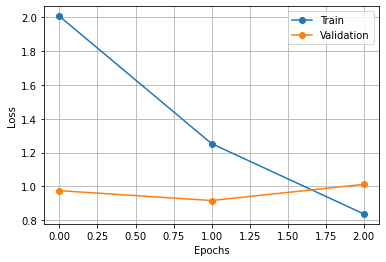

In [ ]:
plot_loss_vs_epochs(train_losses, validation_losses)

**Save the model**

After training, i save the model parameters in a file. I make the evaluations in different notebooks.

In [ ]:
torch.save(model.state_dict(), "model.pt")